# Demo Script
### Automatic License Plate Detection and Recognition System (ALPR)
* Qassim Alwasti
* 28-Aug-2024

- The aim of this script is to showcase our developed ALPR system

# Initial installations for new environments

In [1]:
### Initial installation for new kernel
!pip install ultralytics

In [2]:
!git clone https://github.com/facebookresearch/segment-anything.git


In [ ]:
cd segment-anything

In [ ]:
!pip install -e .

In [ ]:
!pip install tensorflow==2.15.0  #This is the version we're using to train and save the custom CRNN model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Importing the required libraries

In [ ]:
import torch
import torchvision
import sys
import time
import os
import time

import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import cv2 # For Perspective correction using classical Computer Vision

from ultralytics import YOLO # For LP Detection
from segment_anything import sam_model_registry, SamPredictor #For LP segmentation


# Required Libraries for CRNN - LP Recognition
from tensorflow.keras import layers, models
from keras.models import load_model
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.utils import custom_object_scope

# Print versions
print("Python version:", sys.version)
print("PyTorch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)
print("tensorflow version:", tf.__version__)

Python version: 3.10.12 (main, Mar 22 2024, 16:50:05) [GCC 11.4.0]
PyTorch version: 2.3.1+cu121
torchvision version: 0.18.1+cu121
tensorflow version: 2.15.0


# Constants

In [ ]:
# CRNN (LP Recognition) Constants

# Desired image dimensions
img_width = 300
img_height = 100
max_length = 6

# For mapping characters to integers
characters = '0123456789x' # 'x' used for padding
vocabulary = list(characters) #Convert to list

# Required methods

In [ ]:
# Required methods
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([255/255, 0, 0, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def extend_line(x1, y1, x2, y2, length=300):
    line_vector = np.array([x2 - x1, y2 - y1])
    line_vector = line_vector / np.sqrt(np.sum(line_vector**2))

    point1 = np.array([x1, y1]) - line_vector * length
    point2 = np.array([x1, y1]) + line_vector * length

    return (int(point1[0]), int(point1[1]), int(point2[0]), int(point2[1]))


def line_intersection(line1, line2, width, height):
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2

    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if denom == 0:
        return None  # Lines are parallel

    intersect_x = ((x1*y2 - y1*x2)*(x3 - x4) - (x1 - x2)*(x3*y4 - y3*x4)) / denom
    intersect_y = ((x1*y2 - y1*x2)*(y3 - y4) - (y1 - y2)*(x3*y4 - y3*x4)) / denom

    # Check if the intersection point is within the image boundaries
    if 0 <= intersect_x <= width and 0 <= intersect_y <= height:
        return (intersect_x, intersect_y)
    else:
        return None


def find_corners(points):
    if points is None:
        print("Intersections not found or invalid.")
        return None  # Optionally handle the error differently

    # Initialize min/max sums and differences
    min_sum = max_sum = points[0][0] + points[0][1]
    min_diff = max_diff = points[0][0] - points[0][1]

    # Initialize corners
    top_left = top_right = bottom_left = bottom_right = points[0]

    # Find extreme points
    for x, y in points:
        # Check top-left (min x + y)
        if x + y < min_sum:
            min_sum = x + y
            top_left = (x, y)

        # Check bottom-right (max x + y)
        if x + y > max_sum:
            max_sum = x + y
            bottom_right = (x, y)

        # Check top-right (max x - y)
        if x - y > max_diff:
            max_diff = x - y
            top_right = (x, y)

        # Check bottom-left (min x - y)
        if x - y < min_diff:
            min_diff = x - y
            bottom_left = (x, y)

    return [top_left, top_right, bottom_left, bottom_right]

def calculate_bounding_box(corners):
    x_coords = [p[0] for p in corners]
    y_coords = [p[1] for p in corners]
    min_x = min(x_coords)
    max_x = max(x_coords)
    min_y = min(y_coords)
    max_y = max(y_coords)
    return (min_x, min_y, max_x, max_y)


def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")

    # Top-left point will have the smallest sum, bottom-right will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # Compute the difference between points, the top-right point will have the smallest difference,
    # bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

def four_point_transform(image, pts):
    # Ensure pts is a NumPy array
    pts = np.array(pts, dtype="float32")

    # Obtain a consistent order of the points and unpack them individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # Compute the width of the new image, which will be the maximum distance between bottom-right and bottom-left
    # x-coordinates or the top-right and top-left x-coordinates
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))

    # Compute the height of the new image, which will be the maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB))

    # Now that we have the dimensions of the new image, construct the set of destination points to obtain a
    # "birds eye view", (i.e., top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # Compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # Return the warped image
    return warped

def overlay_image(large_image, small_image, x_offset, y_offset):
    # Make a copy to avoid modifying the original large_image
    result_image = large_image.copy()
    # Ensure the small_image fits within the dimensions of large_image
    y_end = min(y_offset + small_image.shape[0], large_image.shape[0])
    x_end = min(x_offset + small_image.shape[1], large_image.shape[1])
    result_image[y_offset:y_end, x_offset:x_end] = small_image[0:y_end-y_offset, 0:x_end-x_offset]
    return result_image


def scaleImage(originalImage, scale_factor=1.5):
    # Get the original dimensions
    original_height, original_width = originalImage.shape[:2]

    # Calculate the new dimensions
    new_width = int(original_width * scale_factor)
    new_height = int(original_height * scale_factor)

    # Resize the image
    scaledImage = cv2.resize(originalImage, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

    return scaledImage


# For LP Recognition
# Mapping integers back to original characters
def decode_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        res = res.replace('x', '')
        return [res]

# Mapping integers back to original characters
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=vocabulary, num_oov_indices=0, mask_token=None, invert=True
)

In [ ]:
# Perform LP Recognition
def LP_Recognition(LP):
    # Preprocess the image
    LP = cv2.cvtColor(LP, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    LP = cv2.resize(LP, (300, 100))  # Resize to (width, height)

    # Transpose the image to switch dimensions
    LP = np.transpose(LP)
    LP = np.flipud(LP) # To correct the image as  transpose flips the images vertically as well
    LP = np.rot90(LP, k=2) # LP numbers will start from top to bottom same direction as convulution
    LP = LP.astype(np.float32) / 255.0  # Normalize to [0, 1] range
    #cv2_imshow(LP)
    LP = np.expand_dims(LP, axis=0)  # Add batch dimension

    # Perform prediction
    predictions = prediction_model.predict(LP)

    # Decode the predictions
    decoded_output = decode_predictions(predictions)
    #QSMprint("Recognized LP: ", decoded_output)
    return decoded_output

# Loading the pre-trained DL models

In [ ]:
#Load the pre-trained YOLO model for LP Detection
preTrainedPath = 'YOLOv9.pt'
yoloModel = YOLO(preTrainedPath)

# Display model information (optional)
yoloModel.info()

YOLOv9e summary: 1,225 layers, 58,145,683 parameters, 0 gradients, 192.7 GFLOPs


(1225, 58145683, 0, 192.6758912)

In [ ]:
# Load SAM predictor
samCheckpoint = "sam_vit_B.pth"
modelType = "vit_b"
device = 'cuda'
sam = sam_model_registry[modelType](checkpoint=samCheckpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

In [ ]:
# Need CTC layer to be defined to successfully load the prediction CRNN pre-trained model
class CTCLayer(layers.Layer):
    def __init__(self, padding_token=0, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost
        self.padding_token = tf.constant(padding_token, dtype=tf.int32)

    def call(self, y_true, y_pred):
        # Convert y_true to int32 to match the padding token type
        y_true = tf.cast(y_true, dtype=tf.int32)

        # Mask the padding tokens
        y_true_masked = tf.where(y_true == -1, self.padding_token, y_true)

        # Compute the training-time loss value and add it to the layer using `self.add_loss()`
        batch_len = tf.cast(tf.shape(y_true_masked)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true_masked)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true_masked, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [ ]:
# Load the pre-trained prediction CRNN model
# Load the model using the layer as a placeholder for CTCLayer
custom_objects = {"CTCLayer": CTCLayer}
model = load_model('CustomCRNN.keras', custom_objects=custom_objects, compile=False)

#extracting layers till the output layer (As we don't need the CTC layer used for training the model)
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)

# Show the model architecture (Optional)
prediction_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 300, 100, 1)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 300, 100, 32)      832       
                                                                 
 pool1 (MaxPooling2D)        (None, 150, 50, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 150, 50, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 75, 25, 64)        0         
                                                                 
 reshape (Reshape)           (None, 75, 1600)          0         
                                                                 
 dense1 (Dense)              (None, 75, 64)            1024

# Main ALPR script

In [ ]:
# Main Function

def ALPR(img):
    start_time = time.time()

    intersections = []

    image = img
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Perform detection
    yolo_start_time = time.time()
    results = yoloModel(image)
    yolo_end_time = time.time()
    yolo_inference = yolo_end_time - yolo_start_time
    print(f"YOLO Inference time: {yolo_inference} seconds")

    # Draw bounding boxes around detected objects
    class_names = ['LP']  # Assuming license plates are class 0
    for result in results:
        boxes = result.boxes.xyxy.cpu().tolist()
        clss = result.boxes.cls.cpu().tolist()

        if len(boxes) > 0:
            # Initialize variables to find the largest box
            for box in boxes:

                x1, y1, x2, y2= box #Get the coordinates of the detected LP
                image2 = image.copy()
                cv2.rectangle(image2, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

            # Crop the image using the rectangle coordinates
            croppedDetectedLP = image.copy()
            croppedDetectedLP = croppedDetectedLP[int(y1):int(y2), int(x1):int(x2)]

        else:
            print("No LPs detected")
            return image, image #just return the same frame back

        #########################################################
        #########              SAM            ###################
        #########################################################
        # Passing the bounding box to SAM model for segmentation
        sam_start_time = time.time()
        predictor.set_image(image)

        input_box = np.array(boxes[0])

        masks, _, _ = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=input_box[None, :],
            multimask_output=False,
        )
        sam_end_time = time.time()
        sam_inference = sam_end_time - sam_start_time
        print(f"SAM Inference time: {sam_inference} seconds")

        # Edge detection on the mask
        masku8 = masks[0].astype(np.uint8)
        subplotNum = 0

        proccess_start_time = time.time()
        # Apply Gaussian Blur on the mask befor edge detection
        blurred_img = cv2.GaussianBlur(masku8, (5, 5), 0)

        # Edge detection on the mask
        edges = cv2.Canny(blurred_img, 0, 1)

        # Dilated mask used for the intersection point filtering
        kernel_size = 5  # You can adjust this size based on the desired dilation amount
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        dilated_mask = cv2.dilate(masku8, kernel, iterations=4)

        # Hough Transform to find lines
        lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=20, minLineLength=10, maxLineGap=5)

        if lines is not None:
            # Create an empty image to draw lines (for visualization)
            line_image = image.copy()

            lines_extended = []
            for line in lines:
                x1, y1, x2, y2 = line[0]
                extended_line = extend_line(x1, y1, x2, y2)
                lines_extended.append(extended_line)
                x1, y1, x2, y2 = extend_line(x1, y1, x2, y2)
                cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 2)


            # Find intersections to determine corners
            intersections = []
            height, width = image.shape[:2]
            for i in range(len(lines_extended)):
                for j in range(i + 1, len(lines_extended)):
                    pt = line_intersection(lines_extended[i], lines_extended[j], width, height)
                    if pt is not None:
                        if dilated_mask[int(pt[1]), int(pt[0])] != 0:  # Check if the intersection is within the mask
                            center = (int(pt[0]), int(pt[1]))
                            intersections.append(center)

        if len(intersections) >= 4: #At least 4 intersections
            cornerPoints = find_corners(intersections)

        else:
            cornerPoints = None
            print("No Corners as not intersections were detected")

        croppedLP = image.copy()
        # Apply the four point transform to obtain your top-down view of the plate
        if cornerPoints is not None:
            warped = four_point_transform(croppedLP, cornerPoints)

            for point in cornerPoints:
                cv2.circle(image, point, 10, (0, 255, 0), -1)

            warped_resized = cv2.resize(warped, (400, 200))  # Resize

            overlayedImage = overlay_image(image, warped_resized, 20, 20)
            proccess_end_time = time.time()
            proccessing_inference = proccess_end_time - proccess_start_time
            print(f"Processing Inference time: {proccessing_inference} seconds")

            # Perform LP Recognition
            rec_start_time = time.time()
            recognizedLP = LP_Recognition(warped_resized) #Run LP Recognition against the LP image
            rec_end_time = time.time()

            rec_inference = rec_end_time - rec_start_time
            print(f"Recognition Inference time: {rec_inference} seconds")

            # Get the dimensions of the overlayedImage
            height, width, _ = overlayedImage.shape

            # Define the font and font scale
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 3

            # Define the color of the text
            color = (50, 255, 50)  # Red color

            # Define the thickness of the text
            thickness = 12

            # Define the height of the rectangle
            rect_height = 100

           # Calculate the position of the rectangle
            x = (width - 400) // 2
            y = 20

            # Draw a rectangle behind the text
            cv2.rectangle(overlayedImage, (x, y), (x+400, y+rect_height), (0,0,0), -1)

            # Loop through each text in the list and write it on the image
            for i, text in enumerate(recognizedLP):
                cv2.putText(overlayedImage, str(text), (x + i*60, y + 80), font, font_scale, color, thickness)

            end_time = time.time()
            print(f"Total ALPR time: {end_time - start_time} seconds")

            return overlayedImage, warped_resized

        return image, image #just return the same frame back

# Testing Results

In [3]:
# Inference single image
'''
image = cv2.imread("SampleImages/1.jpg")
result, LP = ALPR(image)
#plt.imshow(result)
cv2_imshow(result)
''';


0: 480x640 1 0, 80.6ms
Speed: 4.2ms preprocess, 80.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)
YOLO Inference time: 1.1893153190612793 seconds
SAM Inference time: 0.4838078022003174 seconds
Processing Inference time: 0.017023801803588867 seconds
1/1 [==============================] - 2s 2s/step
Recognition Inference time: 1.936647891998291 seconds
Total ALPR time: 3.6329386234283447 seconds


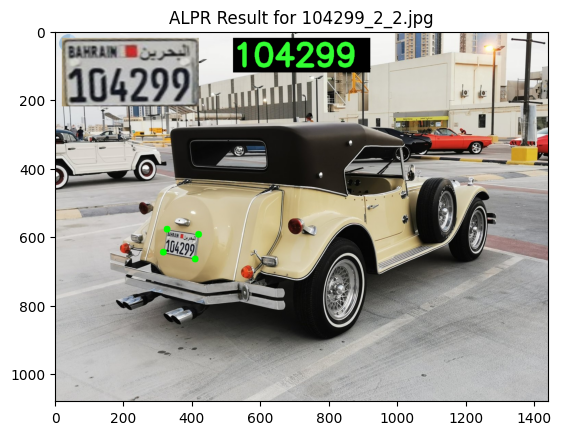


0: 480x640 1 0, 79.5ms
Speed: 3.6ms preprocess, 79.5ms inference, 4.6ms postprocess per image at shape (1, 3, 480, 640)
YOLO Inference time: 0.09660768508911133 seconds
SAM Inference time: 0.4529716968536377 seconds
Processing Inference time: 0.016759634017944336 seconds
1/1 [==============================] - 0s 23ms/step
Recognition Inference time: 0.07767605781555176 seconds
Total ALPR time: 0.6498053073883057 seconds


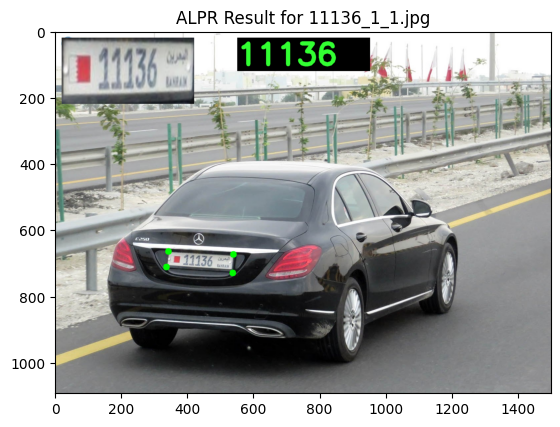


0: 480x640 1 0, 42.2ms
Speed: 3.5ms preprocess, 42.2ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)
YOLO Inference time: 0.05603456497192383 seconds
SAM Inference time: 0.40617799758911133 seconds
Processing Inference time: 0.015460968017578125 seconds
1/1 [==============================] - 0s 25ms/step
Recognition Inference time: 0.09434700012207031 seconds
Total ALPR time: 0.5769975185394287 seconds


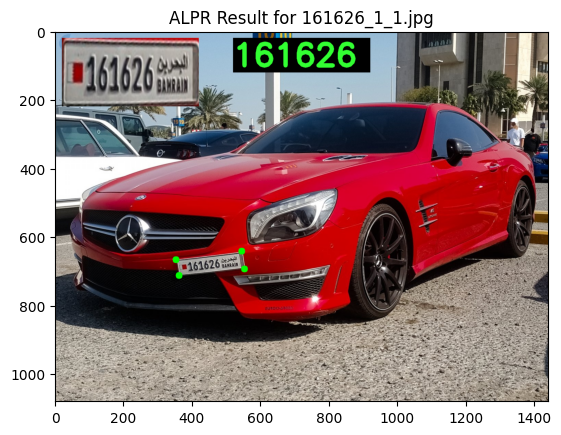


0: 480x640 1 0, 40.5ms
Speed: 3.6ms preprocess, 40.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)
YOLO Inference time: 0.05350780487060547 seconds
SAM Inference time: 0.4105088710784912 seconds
Processing Inference time: 0.020418643951416016 seconds
1/1 [==============================] - 0s 22ms/step
Recognition Inference time: 0.08267688751220703 seconds
Total ALPR time: 0.5726797580718994 seconds


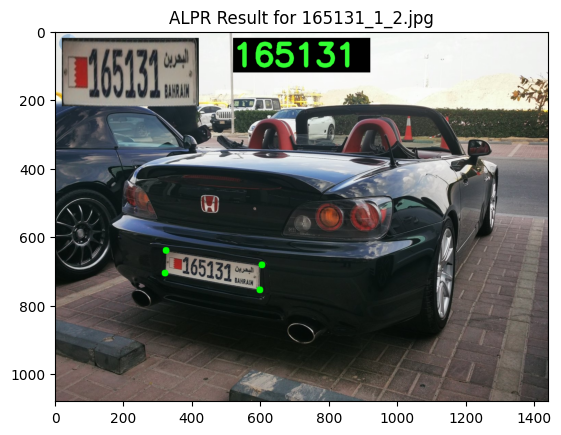


0: 448x640 1 0, 40.9ms
Speed: 3.3ms preprocess, 40.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)
YOLO Inference time: 0.052864789962768555 seconds
SAM Inference time: 0.4019131660461426 seconds
Processing Inference time: 0.014739513397216797 seconds
1/1 [==============================] - 0s 26ms/step
Recognition Inference time: 0.08815646171569824 seconds
Total ALPR time: 0.562777042388916 seconds


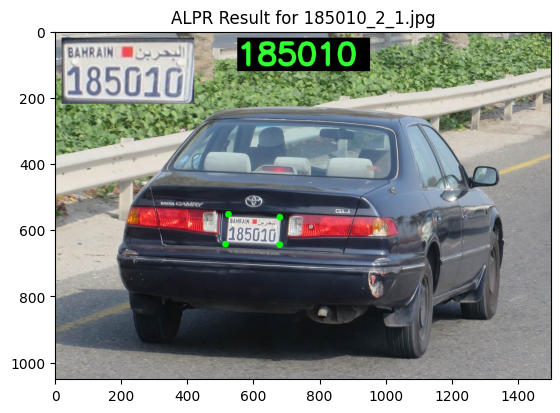


0: 480x640 1 0, 41.3ms
Speed: 3.9ms preprocess, 41.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
YOLO Inference time: 0.05523538589477539 seconds
SAM Inference time: 0.41017794609069824 seconds
Processing Inference time: 0.014328479766845703 seconds
1/1 [==============================] - 0s 28ms/step
Recognition Inference time: 0.08768224716186523 seconds
Total ALPR time: 0.5725324153900146 seconds


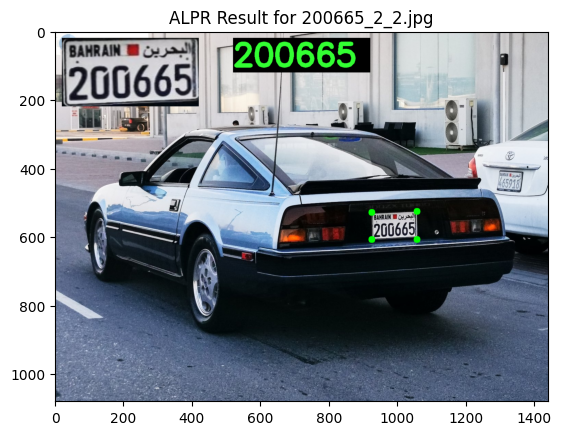


0: 480x640 1 0, 40.1ms
Speed: 3.6ms preprocess, 40.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)
YOLO Inference time: 0.05204415321350098 seconds
SAM Inference time: 0.40818238258361816 seconds
Processing Inference time: 0.012494564056396484 seconds
1/1 [==============================] - 0s 27ms/step
Recognition Inference time: 0.09336400032043457 seconds
Total ALPR time: 0.5708131790161133 seconds


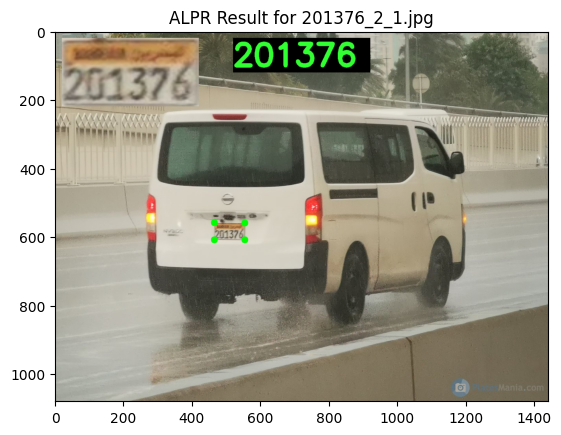


0: 480x640 1 0, 40.4ms
Speed: 4.1ms preprocess, 40.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)
YOLO Inference time: 0.053611040115356445 seconds
SAM Inference time: 0.4096872806549072 seconds
Processing Inference time: 0.013378143310546875 seconds
1/1 [==============================] - 0s 23ms/step
Recognition Inference time: 0.09169411659240723 seconds
Total ALPR time: 0.5724685192108154 seconds


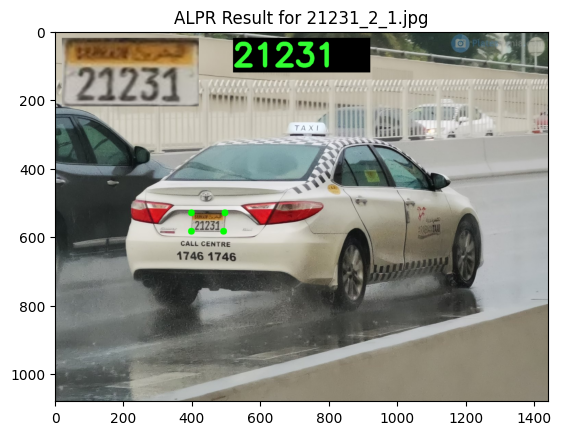


0: 480x640 1 0, 41.0ms
Speed: 3.6ms preprocess, 41.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)
YOLO Inference time: 0.05567431449890137 seconds
SAM Inference time: 0.40580129623413086 seconds
Processing Inference time: 0.014465570449829102 seconds
1/1 [==============================] - 0s 27ms/step
Recognition Inference time: 0.09525108337402344 seconds
Total ALPR time: 0.5757501125335693 seconds


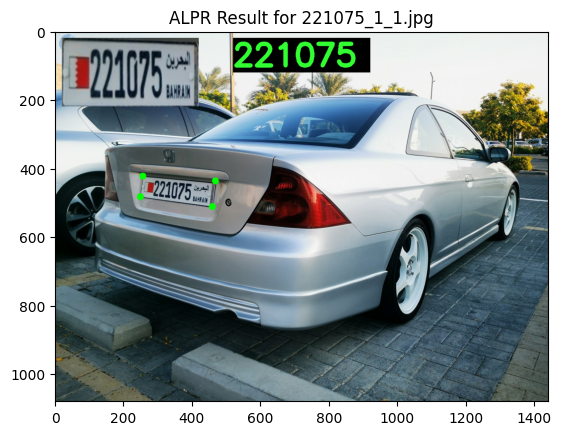


0: 480x640 1 0, 41.1ms
Speed: 4.3ms preprocess, 41.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)
YOLO Inference time: 0.054869651794433594 seconds
SAM Inference time: 0.4116528034210205 seconds
Processing Inference time: 0.015098810195922852 seconds
1/1 [==============================] - 0s 26ms/step
Recognition Inference time: 0.09099674224853516 seconds
Total ALPR time: 0.5786430835723877 seconds


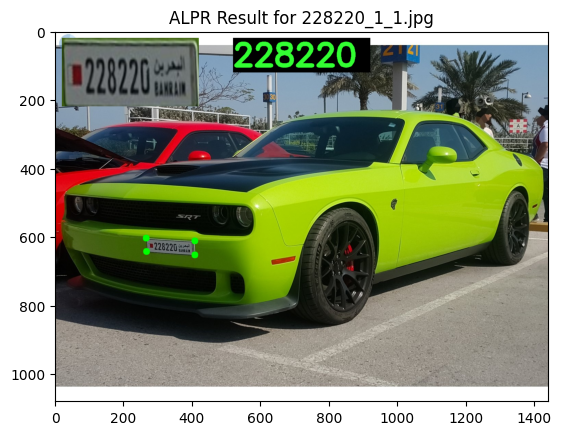


0: 480x640 1 0, 39.9ms
Speed: 6.2ms preprocess, 39.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)
YOLO Inference time: 0.05601644515991211 seconds
SAM Inference time: 0.4079105854034424 seconds
Processing Inference time: 0.016103267669677734 seconds
1/1 [==============================] - 0s 23ms/step
Recognition Inference time: 0.08728671073913574 seconds
Total ALPR time: 0.571993350982666 seconds


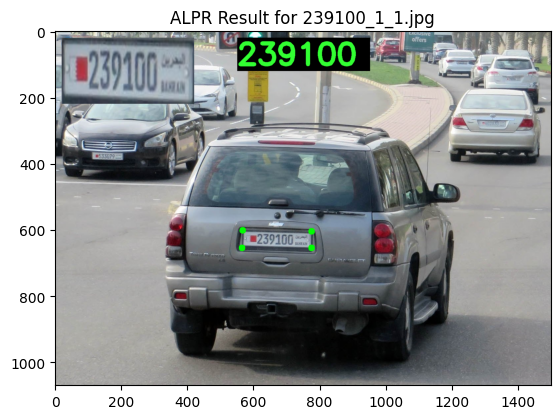


0: 480x640 1 0, 52.0ms
Speed: 3.9ms preprocess, 52.0ms inference, 4.7ms postprocess per image at shape (1, 3, 480, 640)
YOLO Inference time: 0.0713050365447998 seconds
SAM Inference time: 0.4313070774078369 seconds
Processing Inference time: 0.022933006286621094 seconds
1/1 [==============================] - 0s 31ms/step
Recognition Inference time: 0.1038966178894043 seconds
Total ALPR time: 0.6409449577331543 seconds


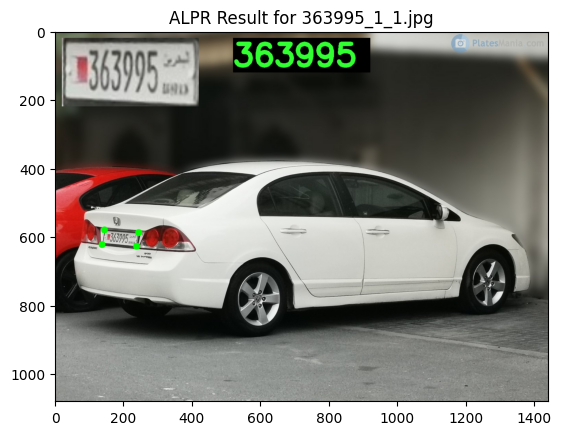


0: 448x640 1 0, 52.4ms
Speed: 7.8ms preprocess, 52.4ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)
YOLO Inference time: 0.06852889060974121 seconds
SAM Inference time: 0.4299015998840332 seconds
Processing Inference time: 0.023897409439086914 seconds
1/1 [==============================] - 0s 33ms/step
Recognition Inference time: 0.1286764144897461 seconds
Total ALPR time: 0.6588134765625 seconds


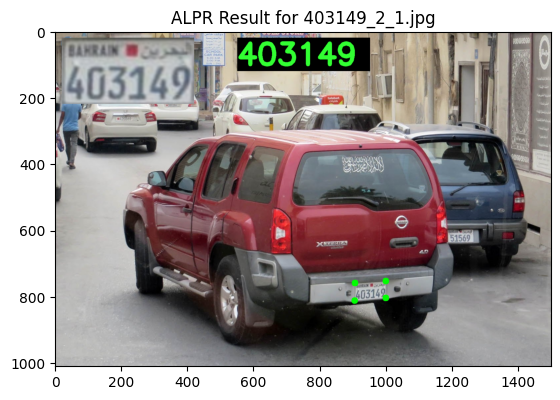


0: 480x640 1 0, 42.7ms
Speed: 3.7ms preprocess, 42.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)
YOLO Inference time: 0.060648441314697266 seconds
SAM Inference time: 0.41927170753479004 seconds
Processing Inference time: 0.017403841018676758 seconds
1/1 [==============================] - 0s 42ms/step
Recognition Inference time: 0.11078596115112305 seconds
Total ALPR time: 0.6140031814575195 seconds


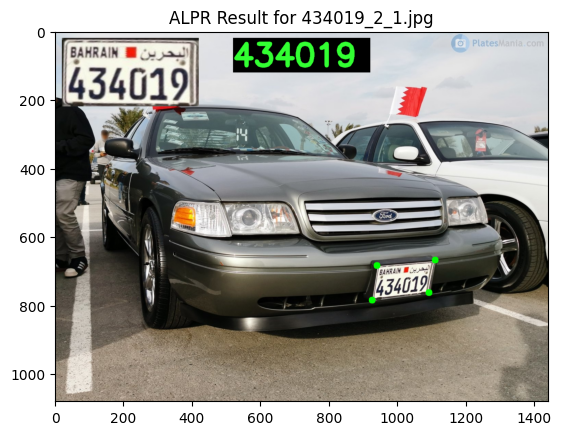


0: 480x640 1 0, 58.2ms
Speed: 3.6ms preprocess, 58.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)
YOLO Inference time: 0.07560467720031738 seconds
SAM Inference time: 0.42716073989868164 seconds
Processing Inference time: 0.022889375686645508 seconds
1/1 [==============================] - 0s 41ms/step
Recognition Inference time: 0.11294245719909668 seconds
Total ALPR time: 0.6450748443603516 seconds


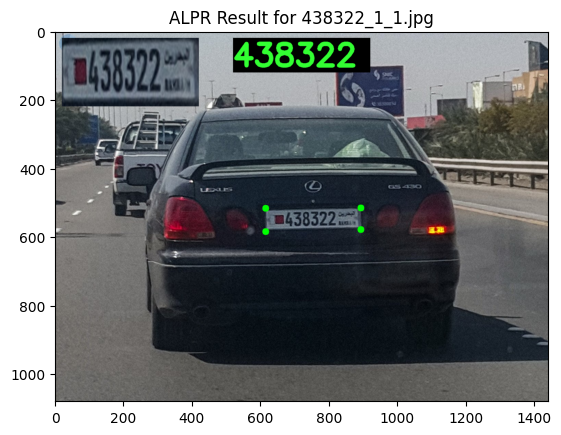


0: 480x640 1 0, 43.0ms
Speed: 3.7ms preprocess, 43.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)
YOLO Inference time: 0.05911970138549805 seconds
SAM Inference time: 0.43102049827575684 seconds
Processing Inference time: 0.018320560455322266 seconds
1/1 [==============================] - 0s 41ms/step
Recognition Inference time: 0.12981224060058594 seconds
Total ALPR time: 0.6454284191131592 seconds


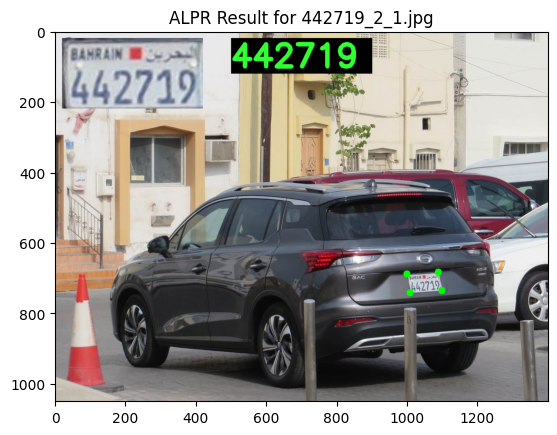


0: 480x640 1 0, 40.4ms
Speed: 5.0ms preprocess, 40.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)
YOLO Inference time: 0.053859710693359375 seconds
SAM Inference time: 0.40702176094055176 seconds
Processing Inference time: 0.01333928108215332 seconds
1/1 [==============================] - 0s 22ms/step
Recognition Inference time: 0.07665562629699707 seconds
Total ALPR time: 0.5556929111480713 seconds


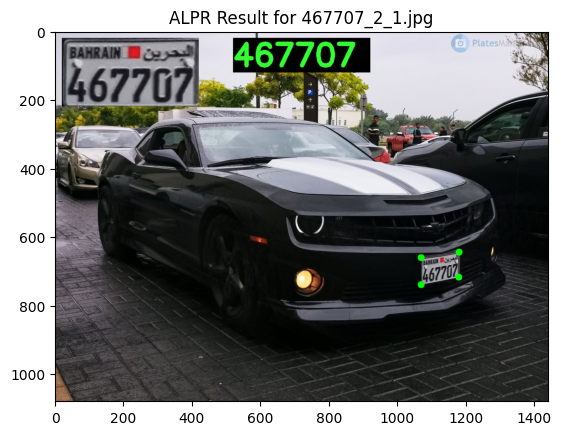


0: 480x640 1 0, 40.7ms
Speed: 3.8ms preprocess, 40.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)
YOLO Inference time: 0.05287885665893555 seconds
SAM Inference time: 0.42036962509155273 seconds
Processing Inference time: 0.013443470001220703 seconds
1/1 [==============================] - 0s 23ms/step
Recognition Inference time: 0.07463264465332031 seconds
Total ALPR time: 0.5660543441772461 seconds


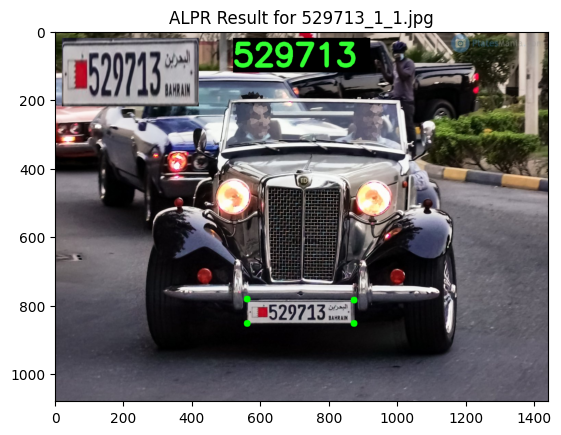


0: 480x640 1 0, 40.8ms
Speed: 4.2ms preprocess, 40.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)
YOLO Inference time: 0.055635929107666016 seconds
SAM Inference time: 0.4186890125274658 seconds
Processing Inference time: 0.016746044158935547 seconds
1/1 [==============================] - 0s 24ms/step
Recognition Inference time: 0.08025836944580078 seconds
Total ALPR time: 0.5760893821716309 seconds


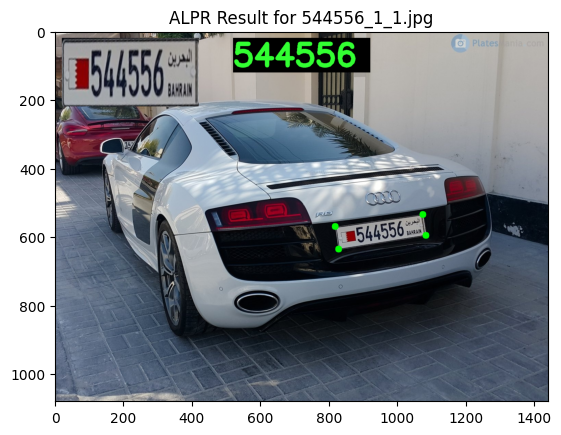

In [ ]:
# Inference all images in a directory
def load_images(directory):
    images = []
    filenames = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(directory, filename)
            image = cv2.imread(image_path)
            images.append(image)
            filenames.append(filename)
    return images, filenames

def run_ALPR_on_directory(directory):
    images, filenames = load_images(directory)
    for image, filename in zip(images, filenames):
        result, LP = ALPR(image)
        # Process the result and LP here
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.title(f"ALPR Result for {filename}")
        plt.show()

# Run the ALPR method on all images in the "SampleImages" directory
TestImagesDir = 'TestImages/'
run_ALPR_on_directory(TestImagesDir)
